In [ ]:
!pip install datasets
!pip install pinecone-client
!pip install koreanize-matplotlib

In [ ]:
from datasets import load_dataset
import re
import pandas as pd
import concurrent.futures

dataset = load_dataset(path="joonhok-exo-ai/korean_law_open_data_precedents", split="train")
dataset_df = pd.DataFrame(dataset)

In [ ]:
import pandas as pd

# 해당 키워드가 들어간 사건명을 검색하고 key값 저장
keywords = {
    "도로교통법":{"도로","음주","뺑소니"},
    "살인":{"살인"},
    "절도":{"절도","불법사용","침입절도"},
    "장물":{"장물"},
    "사기":{"사기","컴퓨터등사용사기","부당이득","편의시설부정이용","전기통신금융사기","보험사기"},
    "횡령":{"횡령"},
    "배임":{"배임"},
    "손괴":{"손괴"},
    "강도":{"강도"},
    "방화":{"방화"},
    "성폭력":{"성폭력","강간","특수강도강간","카메라등이용촬영","공중밀집에서의추행","음란물"},
    "폭행":{"폭행","폭력행위"},
    "상해":{"상해"},
    "협박":{"협박"},
    "공갈":{"공갈"},
    "약취/유인":{"약취","유인","부녀매매","국외이송"},
    "체포/감금":{"체포","감금"},
    "위조범죄":{"통화","유가","인지","우표","문서","인장"},
    "공무원범죄":{"직무","직권","수뢰","증뢰"},
    "도박":{"도박","복표"},
    "과실범죄":{"과실","실화"},
    "명예":{"명예"},
    "권리행사방해":{"권리행사방해"},
    "주거침입":{"주거침입"},
    "비밀침해":{"비밀침해"},
    "유기":{"유기"},
    "교통방해":{"교통방해"},
    "도주/범죄은닉":{"도주","은닉"},
    "위증과증거인멸":{"위증","증거인멸"},
    "무고":{"무고"},
    "가정폭력":{"가정폭력"},
    "개인정보보호법":{"개인정보"},
    "건설":{"건설","건축"},
    "게임산업진흥법":{"게임"},
    "고용보험법":{"고용보험"},
    "공유수면관리":{"공유수면"},
    "공인중개사법":{"공인중개"},
    "공중위생법":{"공중위생"},
    "공직선거법":{"공직선거"},
    "관세법":{"관세"},
    "교통사고처리특례법":{"교통사고"},
    "국가기술자격법":{"국가기술자격"},
    "국가보안법":{"국가보안"},
    "국민체육진흥법":{"국민체육"},
    "근로기준법":{"근로","퇴직","급여"},
    "노동조합":{"노동"},
    "농수산물":{"농수산물"},
    "도시및주거환경":{"도시","주거환경"},
    "공정거래법":{"독점","공정거래"},
    "마약류관리에관한법률":{"마약"},
    "변호사법":{"변호사"},
    "병역법":{"병역"},
    "부동산":{"부동산"},
    "부정경쟁방지및영업비밀보호":{"부정경쟁","영업비밀"},
    "부정수표":{"부정수표"},
    "사해행위":{"사해행위"},
    "산업안전보건법":{"산업안전"},
    "산지관리법":{"산지"},
    "상표법":{"상표"},
    "선박":{"선박"},
    "성매매알선":{"성매매"},
    "식품위생법":{"식품위생"},
    "아동˙청소년":{"아동·청소년의성보호","아동"},
    "약사법":{"약사법"},
    "외국환거래법":{"외국환"},
    "의료법":{"의료"},
    "자동차":{"자동차"},
    "자본시장과금융투자업":{"자본시장","금융투자"},
    "저작권법":{"저작권"},
    "전자금융거래법":{"전자금융"},
    "정보통신망":{"정보통신망"},
    "조세범처벌법":{"조세범"},
    "주민등록법":{"주민등록법"},
    "주택법":{"주택"},
    "집회및시위":{"집회","시위"},
    "총포·도검·화약류단속":{"총포","도검","화약류"},
    "특허법":{"특허"},
    "폐기물관리법":{"폐기물"}
}
# 키워드를 범죄로 매핑
crime_to_keyword = {crime: keyword for keyword, crimes in keywords.items() for crime in crimes}

# 필터링된 사건 수집
filtered_cases = {}
for case in dataset_df['사건명'].unique():
    if case is not None:
        matched = False
        for crime, keyword in crime_to_keyword.items():
            if crime in case:
                if keyword in filtered_cases:
                    filtered_cases[keyword].add(case)
                else:
                    filtered_cases[keyword] = {case}
                matched = True
                break
        if not matched:
            if "기타" in filtered_cases:
                filtered_cases["기타"].add(case)
            else:
                filtered_cases["기타"] = {case}

# 모든 필터링된 사건을 중복 없이 통합
all_filtered_cases = set()
for cases in filtered_cases.values():
    all_filtered_cases.update(cases)

filtered_dataset_df = dataset_df[dataset_df['사건명'].isin(all_filtered_cases)]

# '분류' 열을 추가하고 키워드에 해당하는 값 할당
filtered_dataset_df['분류'] = filtered_dataset_df['사건명'].apply(lambda x: next((key for key, value in keywords.items() if any(keyword in x for keyword in value)), None))

# '기타'로 분류되는 행 추가
filtered_dataset_df.loc[filtered_dataset_df['분류'].isnull(), '분류'] = '기타'

filtered_dataset_df = filtered_dataset_df[filtered_dataset_df['분류'] != '기타']

# 결과 출력
filtered_dataset_df



<ipython-input-46-d49d5cb52d80>:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_dataset_df['분류'] = filtered_dataset_df['사건명'].apply(lambda x: next((key for key, value in keywords.items() if any(keyword in x for keyword in value)), None))


,판례정보일련번호,사건명,사건번호,선고일자,선고,법원명,사건종류명,판결유형,판시사항,판결요지,참조조문,참조판례,전문,분류
2,85835,부동산소유권이전등기,4281민상362,19480407,선고,대법원,민사,선고,가. 소송위임 흠결의 항변과 당해 이원의 인증 나. 계약해제존재의 가항변에 대한 판...,가. 소송위임장이 사문서인 경우에 당사자 일방이 그 소송위임의 흠결을 주장한 때에는...,"민사소송법 제80조 , 제137조, 제395조",None,"【원고, 피상고인】\n안유길\n【피고, 상고인】\n최석희\n【원심판결】\n서울지방법...",부동산
7,85833,부동산이전등기말소,4281민상314,19490402,선고,대법원,민사,판결,부동산소유권이전 가등기권리자의 제3자에 대한 소유권이전 본등기의 말소청구권,가. 부동산소유권이전 가등기후에 등기의무자가 제3자에게 그 부동산소유권이전의 본등기...,부동산등기법 제2조,None,"【원고, 상고인】\n박희승\n【피고, 피상고인】\n조태환 외 32인\n【원심판결】\...",부동산
10,85839,국가보안법위반,4283형상72,19500320,선고,대법원,형사,판결,가. 연속범중의 일부행위에 대한 위법과 상고이유의 적부 나. (가) 남로당산하단체인...,가. 연속범을 구성하는 수개행위 중 그 일부행위에 대한 판단에 위법이었다 할 지라도...,"국가보안법 제4조, 제1조 제3호 , 형사소송법 제411조, 형법 제21조",None,"【상고인, 피고인】\n【원 심】\n서울고등법원\n【주 문】\n원판결을 파훼한다.\n...",국가보안법
11,215267,국가보안법제3조급법령제19호제4조나항각위반피고,4283형상7,19501120,선고,대법원,형사,판결,긴급구속사건과 사법경찰관의 피의자신문조서 작성권의 존부,피의자를 긴급구속한 사법경찰관은 형사소송법의 개정 제8조에 의하여 그 구속을 유지하...,"형사소송법 제8조, 제56조, 제343조",None,"【피고인, 상고인】\n피고인\n【변 호 인】\n김성재\n【주 문】\n본건 상고를 기...",국가보안법
12,85837,국가보안법위반,4283형상14,19501127,선고,대법원,형사,판결,국가보안법 제1조 제3호의 죄와 동법 제3조의 죄와의 죄질의 동일 여부,국가보안법 제1조 제3호의 결사는 국헌을 위배하여 정부를 잠칭하거나 국가를 변난할 ...,"국가보안법 제1조 제2항, 제3조 제2항 , 형법 제55조, 제45조",None,"【상고인, 피고인】\n【원심판결】\n제1심 부산지방법원, 제2심 동지방법원\n【주 ...",국가보안법
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85644,212537,종합부동산세등부과처분취소,2012두26852,20141127,선고,대법원,세무,판결,"[1] 신탁재산이 신탁법에 따른 신탁등기나 등록이 마쳐지지 아니한 경우, 신탁재산에...",[1] 구 지방세법(2010. 3. 31. 법률 제10221호로 전부 개정되기 전의...,[1] 구 지방세법(2010. 3. 31. 법률 제10221호로 전부 개정되기 전의...,"[1] 대법원 1993. 4. 27. 선고 92누8163 판결(공1993하, 160...","【원고, 피상고인】 상도134지역주택조합 (소송대리인 법무법인(유한) 한결 담당변호...",부동산
85645,179916,공직선거법위반·국가정보원법위반,2014노2820,20150209,선고,서울고등법원,형사,판결,None,None,None,None,"【피 고 인】\n【항 소 인】 피고인들, 검사\n【검 사】 진재선(기소), 박...",공직선거법
85646,188351,뇌물수수·뇌물공여·특정범죄가중처벌등에관한법률위반(뇌물)·변호사법위반·특정경제범죄가중...,"2014고합587, 441(병합), 603(병합), 802(병합)",20151127,선고,부산지방법원,형사,판결,None,None,None,None,"【피 고 인】\n【검 사】 전현민, 윤철민(기소), 천헌주, 서동민(공판)\n...",사기
85647,188019,사기·보조금관리에관한법률위반(일부인정된죄명보조금의예산및관리에관한법률위반),2015노4075,20160526,선고,부산지방법원,형사,판결,None,None,None,None,"【피 고 인】\n【항 소 인】 피고인들\n【검 사】 진호식, 권오승(각 기소)...",사기


In [ ]:
# '분류'가 '폭행'인 행만 필터링
assault_cases = filtered_dataset_df[filtered_dataset_df['분류'] == '폭행']

# '사건명' 열만 추출하여 리스트로 변환
assault_case_names = assault_cases['사건명'].unique().tolist()

# 리스트를 텍스트 파일로 저장
with open('assault_case_names.txt', 'w', encoding='utf-8') as f:
    for name in assault_case_names:
        f.write(name + '\n')

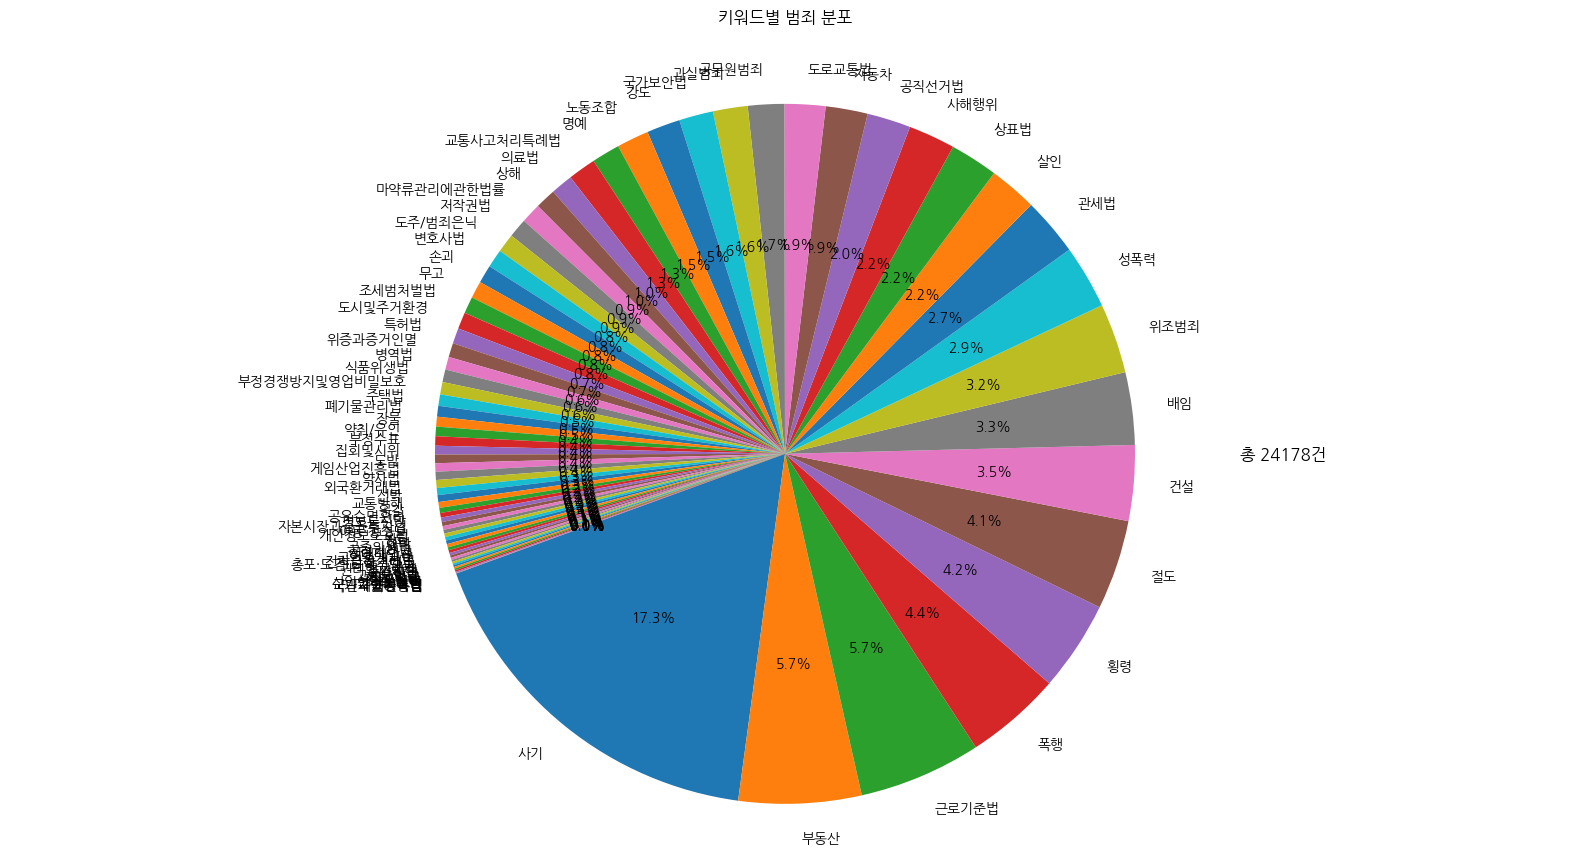

In [ ]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 각 키워드에 해당하는 사건 수 계산
keyword_counts = filtered_dataset_df['분류'].value_counts()

# 파이차트 그리기
plt.figure(figsize=(20, 10))
plt.pie(keyword_counts, labels=keyword_counts.index, autopct='%1.1f%%', startangle=200)
plt.title('키워드별 범죄 분포',y=1.05)
plt.axis('equal')  # 원형 모양 유지

# 총 개수 표시
total_cases = len(filtered_dataset_df)
plt.text(1.3, 0, f'총 {total_cases}건', fontsize=12, verticalalignment='center')

plt.show()


In [ ]:
pwd

'/content'

In [ ]:
ls -al

total 58384
drwxr-xr-x 1 root root     4096 May  7 01:52 ./
drwxr-xr-x 1 root root     4096 May  7 01:29 ../
drwxr-xr-x 4 root root     4096 May  3 13:20 .config/
-rw-r--r-- 1 root root 19922944 May  7 01:54 NewsResult_20240203-20240304.xlsx
-rw-r--r-- 1 root root 19922944 May  7 01:54 NewsResult_20240305-20240402.xlsx
-rw-r--r-- 1 root root 19922944 May  7 01:54 NewsResult_20240403-20240506.xlsx
drwxr-xr-x 1 root root     4096 May  3 13:20 sample_data/


##뉴스 데이터 불러오기(2024-02-03 ~ 2024-05-06 범죄 뉴스 총 6만개)

In [ ]:
import pandas as pd

# Excel 파일을 읽어와서 데이터프레임으로 저장
df1 = pd.read_excel('NewsResult_20240403-20240506.xlsx')
df2 = pd.read_excel('NewsResult_20240305-20240402.xlsx')
df3 = pd.read_excel('NewsResult_20240203-20240304.xlsx')

# 세 개의 데이터프레임을 concat하여 하나의 데이터프레임으로 결합
combined_df = pd.concat([df1, df2, df3])

combined_df.head()

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,사건/사고 분류3,인물,위치,기관,키워드,특성추출(가중치순 상위 50개),본문,URL,분석제외 여부
0,1.010010e+07,20240506,스포츠서울,원성윤 기자(socool@sportsseoul.com),"임영웅도 못한 걸 ‘찬또배기’가 해냈다 KBS ‘뮤뱅’, 17년만에 트로트 장르 1...",문화>방송_연예,사회>미디어,문화>음악,범죄>범죄일반>방화,NaN,NaN,"조선,강진,임영웅,이찬원","미국,장르,화력,서울월드컵경기장에","문화평론가,KBS2,뮤뱅,soc,KBS-MBC,물고기뮤직,케이팝,뮤직뱅크,KBS,N...","임영웅,찬또배기,KBS,뮤뱅,17년,트로트,장르,SS,뮤직,가수,이찬원,사진,이찬원...","이찬원,1위,임영웅,트로트,뮤직뱅크,아일릿,kbs,도영,판매량,빌보드,케이팝,강진,...",가수 이찬원. 사진|이찬원 공식 채널\n \n\n[스포츠서울 | 원성윤 기자] ‘찬...,https://www.sportsseoul.com/news/read/1425979,NaN
1,4.100058e+06,20240506,노컷뉴스,광주CBS 김한영 기자\n김한영,전남 영광서 지인에게 흉기 휘두른 50대 입건,사회>사건_사고,지역>강원,지역>광주,범죄>범죄일반>살인,NaN,NaN,NaN,"영광서,전남,영광군","영광경찰서,영광읍,경찰,전남","지인,전남,영광서,흉기,입건,흉기,지인,50대,경찰,전남,영광경찰서,살인,미수,혐의...","전남,50대,영광군,a씨,영광서,b씨,영광경찰서,영광읍,혐의,경찰,흉기,지인,조사,...",흉기를 휘둘러 지인을 다치게 한 50대가 경찰에 붙잡혔다. \n \n전남 영광경찰서...,NaN,NaN
2,1.300201e+06,20240506,강원일보,김인규기자 kimingyu1220@kwnews.co.kr,내 집 앞에 식당 손님 차?” 고무망치로 업주 때때린 혐의로 50대 남성 집유,사회>사건_사고,사회>여성,사회>교육_시험,범죄>범죄일반>폭행,NaN,NaN,박현진,"원주,상해","형사2단독,춘천지법,원주지원","식당,고무망치,업주,혐의,집유,남성,춘천지법,원주,지원,징역,선고,집행,유예,고무망...","고무망치,춘천지법,집행유예,박현진,원주,원주지원,상해,부장판사,특수상,특수상해,불구...",본인의 주택 앞에 손님 차량을 주차했다는 이유로 식당 업주와 시비 중 머리를 고무망...,https://www.kwnews.co.kr/page/view/20240506103...,NaN
3,2.100051e+06,20240506,대한경제,권혁식,"[사설] 尹 대통령 회견, ‘특검’ 물타기 아닌 소통과 공감 담아내야",정치>청와대,정치>국회_정당,정치>행정_자치,범죄>기업범죄>거래제한,NaN,NaN,"윤석열,尹,김건희,이종섭,이재명","간호법,양곡법","민주당,더불어민주당,해병대,도이치모터스,국무위","회견,대통령,특검,소통,공감,윤석열,대통령,2주년,취임,5월,기자회견,대통령,회견,...","민주당,도이치모터스,해병대,간호법,양곡법,더불어민주당,이재명,관심사,특검법,연금개혁",윤석열 대통령이 오는 9일 취임 2주년(5월10일) 기자회견을 연다고 한다. 대통령...,http://www.dnews.co.kr/uhtml/view.jsp?idxno=20...,NaN
4,1.200501e+06,20240506,경기신문,박진석 기자,보험사기 1조 돌파로 경찰 특별단속 보험사 주먹구구식 사건 처리 개선해야,지역>강원,지역>경북,사회>노동_복지,범죄>범죄일반>사기,사고>교통사고>노상사고,NaN,NaN,안산시,"경기신문,경찰","돌파,보험,사기,경찰,특별,단속,보험사,주먹구구식,사건,처리,개선,보험사기,적발액,...","보험사기,보험사,교통사고,적발액,1조,만큼,보험금,가해자,경기신문,안산시,자동차","지난해 보험사기 적발액이 1조 원에 달하면서 경찰이 특별 단속에 나선 가운데, 보험...",https://www.kgnews.co.kr/news/article.html?no=...,NaN


##뉴스 데이터 불러오기(2024-02-03 ~ 2024-05-06 범죄 뉴스 총 6만개)

In [ ]:
# 유의미한 column 추출
selected_df = combined_df[['제목', '특성추출(가중치순 상위 50개)', '사건/사고 분류1']]
selected_df

,제목,특성추출(가중치순 상위 50개),사건/사고 분류1
0,"임영웅도 못한 걸 ‘찬또배기’가 해냈다 KBS ‘뮤뱅’, 17년만에 트로트 장르 1...","이찬원,1위,임영웅,트로트,뮤직뱅크,아일릿,kbs,도영,판매량,빌보드,케이팝,강진,...",범죄>범죄일반>방화
1,전남 영광서 지인에게 흉기 휘두른 50대 입건,"전남,50대,영광군,a씨,영광서,b씨,영광경찰서,영광읍,혐의,경찰,흉기,지인,조사,...",범죄>범죄일반>살인
2,내 집 앞에 식당 손님 차?” 고무망치로 업주 때때린 혐의로 50대 남성 집유,"고무망치,춘천지법,집행유예,박현진,원주,원주지원,상해,부장판사,특수상,특수상해,불구...",범죄>범죄일반>폭행
3,"[사설] 尹 대통령 회견, ‘특검’ 물타기 아닌 소통과 공감 담아내야","민주당,도이치모터스,해병대,간호법,양곡법,더불어민주당,이재명,관심사,특검법,연금개혁",범죄>기업범죄>거래제한
4,보험사기 1조 돌파로 경찰 특별단속 보험사 주먹구구식 사건 처리 개선해야,"보험사기,보험사,교통사고,적발액,1조,만큼,보험금,가해자,경기신문,안산시,자동차",범죄>범죄일반>사기
...,...,...,...
19995,‘황야’ 마동석 “액션은 내 인생의 전부” [쿠키인터뷰],"마동석,남산,마석도,만큼,넷플릭스,변승민,수나,액션물,랩틸리언,범죄도시,허명행,록키...",범죄>범죄일반>폭행
19996,"털모자 쓴 배현진, 피습후 첫 행사 한동훈 동행 [포착]","배현진,위원장,이재명,한동훈,품격,서울,대원,소방관,가락동,사흘간,음모론,손가락질,...",범죄>범죄일반>방화
19997,다음주 금융당국 일정,"간담회,금감원장,금감원,이용자,위원장,업무계획,금융위,부위원장,서울청사,금융위원장,...",범죄>범죄일반>사기
19998,"1조원 넘게 뜯어냈다 ""세계 0.1% 부자될 것"" 5060 등친 수법","해피캐쉬,농산물,휴스템코리아,가입비,불구속,9레벨,1조,회원가입,회원가입비,2억,폼...",범죄>범죄일반>사기


In [ ]:
def classify_title(title):
    for key, value in keywords.items():
        if any(keyword in title for keyword in value):
            return key
    # 없다면 원래 분류명 저장
    return selected_df.loc[selected_df['제목'] == title, '사건/사고 분류1'].str.split('>').str[-1].values[0]

In [ ]:
from tqdm import tqdm

# 분류 값을 생성하여 새로운 열에 저장
tqdm.pandas()  # tqdm의 progress_apply 사용
selected_df['분류'] = selected_df['제목'].progress_apply(classify_title)


100%|██████████| 60000/60000 [03:26<00:00, 290.97it/s]
<ipython-input-49-e6d964a4e17d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['분류'] = selected_df['제목'].progress_apply(classify_title)


In [ ]:
selected_df

,제목,특성추출(가중치순 상위 50개),사건/사고 분류1,분류
0,"임영웅도 못한 걸 ‘찬또배기’가 해냈다 KBS ‘뮤뱅’, 17년만에 트로트 장르 1...","이찬원,1위,임영웅,트로트,뮤직뱅크,아일릿,kbs,도영,판매량,빌보드,케이팝,강진,...",범죄>범죄일반>방화,방화
1,전남 영광서 지인에게 흉기 휘두른 50대 입건,"전남,50대,영광군,a씨,영광서,b씨,영광경찰서,영광읍,혐의,경찰,흉기,지인,조사,...",범죄>범죄일반>살인,살인
2,내 집 앞에 식당 손님 차?” 고무망치로 업주 때때린 혐의로 50대 남성 집유,"고무망치,춘천지법,집행유예,박현진,원주,원주지원,상해,부장판사,특수상,특수상해,불구...",범죄>범죄일반>폭행,폭행
3,"[사설] 尹 대통령 회견, ‘특검’ 물타기 아닌 소통과 공감 담아내야","민주당,도이치모터스,해병대,간호법,양곡법,더불어민주당,이재명,관심사,특검법,연금개혁",범죄>기업범죄>거래제한,거래제한
4,보험사기 1조 돌파로 경찰 특별단속 보험사 주먹구구식 사건 처리 개선해야,"보험사기,보험사,교통사고,적발액,1조,만큼,보험금,가해자,경기신문,안산시,자동차",범죄>범죄일반>사기,사기
...,...,...,...,...
19995,‘황야’ 마동석 “액션은 내 인생의 전부” [쿠키인터뷰],"마동석,남산,마석도,만큼,넷플릭스,변승민,수나,액션물,랩틸리언,범죄도시,허명행,록키...",범죄>범죄일반>폭행,폭행
19996,"털모자 쓴 배현진, 피습후 첫 행사 한동훈 동행 [포착]","배현진,위원장,이재명,한동훈,품격,서울,대원,소방관,가락동,사흘간,음모론,손가락질,...",범죄>범죄일반>방화,방화
19997,다음주 금융당국 일정,"간담회,금감원장,금감원,이용자,위원장,업무계획,금융위,부위원장,서울청사,금융위원장,...",범죄>범죄일반>사기,도로교통법
19998,"1조원 넘게 뜯어냈다 ""세계 0.1% 부자될 것"" 5060 등친 수법","해피캐쉬,농산물,휴스템코리아,가입비,불구속,9레벨,1조,회원가입,회원가입비,2억,폼...",범죄>범죄일반>사기,사기


In [ ]:
selected_df['분류'].unique()
# '분류' 열에서 중복되는 column 통합
selected_df['분류'] = selected_df['분류'].replace(['성추행', '음란물', '성희롱', '성매매', '성폭행'], '성폭력')
selected_df['분류'] = selected_df['분류'].replace(['마약류관리에관한법률'], '마약')
#범죄가 아닌 기사 drop
selected_df = selected_df[~selected_df['분류'].isin(['거래제한', '내부자거래', '계약위반','반독점범죄'])]

<ipython-input-50-83ae0d17bc69>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['분류'] = selected_df['분류'].replace(['성추행', '음란물', '성희롱', '성매매', '성폭행'], '성폭력')
<ipython-input-50-83ae0d17bc69>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['분류'] = selected_df['분류'].replace(['마약류관리에관한법률'], '마약')


In [ ]:
result = selected_df[(selected_df['분류'] == '도로교통법') & (selected_df['제목'].str.contains('음주|뺑소니'))]

len(result)

341

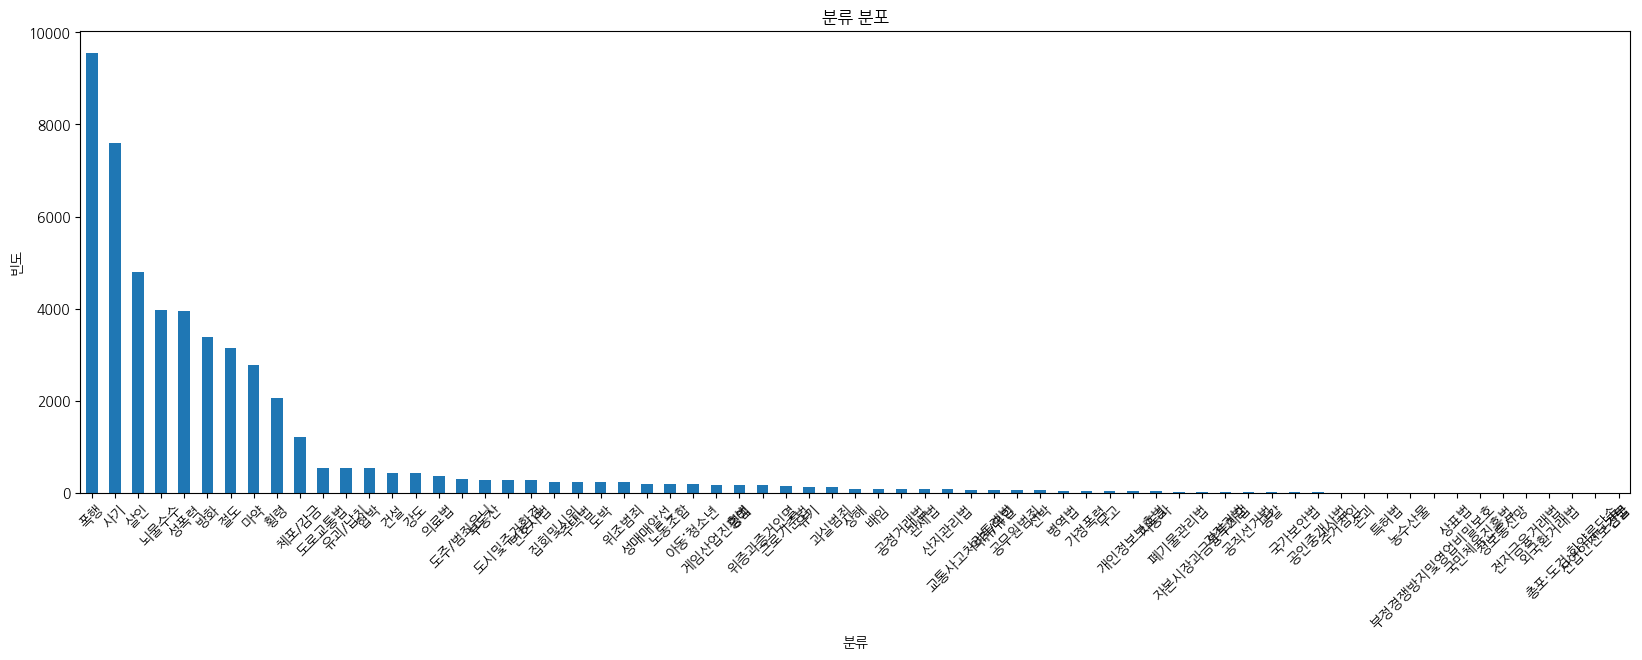

plt로 보여진 총 개수: 49869


In [ ]:
import matplotlib.pyplot as plt
import koreanize_matplotlib
# 분류 열의 값의 빈도 계산
category_counts = selected_df['분류'].value_counts()

# 막대 그래프로 분류 분포 시각화
plt.figure(figsize=(20, 6))
category_counts.plot(kind='bar')
plt.title('분류 분포')
plt.xlabel('분류')
plt.ylabel('빈도')
plt.xticks(rotation=45)  # x축 레이블 회전
plt.show()

# plt로 보여진 총 개수
total_count_shown = category_counts.sum()
print("plt로 보여진 총 개수:", total_count_shown)

In [ ]:
#특성추출(가중치순 상위 50개) tf-idf 벡터화
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
# TF-IDF 벡터화를 위한 객체 생성
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# 특성 추출 열을 TF-IDF 벡터화하여 변환
tfidf_matrix = tfidf_vectorizer.fit_transform(selected_df['특성추출(가중치순 상위 50개)'])

# 결과 확인
tfidf_matrix

with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

In [ ]:
from sklearn.model_selection import train_test_split

# Feature와 Target 분리
X = tfidf_matrix  # TF-IDF 벡터

selected_df = selected_df[selected_df['분류'].notna()]

y = selected_df['분류'].astype(str)  # 분류

# Train과 Test 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)


## GridSearchCV로 최적의 파라미터 탐색

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

# 모델 생성
decision_tree_model = DecisionTreeClassifier(random_state=42)

# 파라미터 그리드 설정
param_grid = {
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 10, 20]
}

# StratifiedKFold 설정
stratified_kfold = StratifiedKFold(n_splits=5)

# 그리드 서치 실행 (n_jobs=-1은 사용 가능한 모든 코어 사용)
grid_search = GridSearchCV(estimator=decision_tree_model, param_grid=param_grid, cv=stratified_kfold, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적 파라미터와 최고 성능 출력
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'max_depth': 40, 'min_samples_split': 2}
Best score: 0.39979166666666666


In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# StratifiedKFold 설정
cv = StratifiedKFold(n_splits=5)

# Random Forest 파라미터 그리드 설정
rf_params = {
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'n_estimators': [100, 300, 500]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                       param_grid=rf_params, cv=cv, scoring='accuracy')
rf_grid.fit(X_train, y_train)
print("Random Forest best parameters:", rf_grid.best_params_)

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
# StratifiedKFold 설정
cv = StratifiedKFold(n_splits=5)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
# XGBoost 파라미터 그리드 설정
xgb_params = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 300, 500]
}
xgb_grid = GridSearchCV(xgb.XGBClassifier(random_state=42, tree_method='gpu_hist'),
                        param_grid=xgb_params, cv=cv, scoring='accuracy')
xgb_grid.fit(X_train, y_train_encoded)
print("XGBoost best parameters:", xgb_grid.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:21:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:21:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [02:21:48] WARNING: /workspace/src/common/error_msg.cc:58: Fall

XGBoost best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


## 모델 학습

In [ ]:
# DecisionTreeClassifier 모델 불러오기
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import LabelEncoder
import time


start_time = time.time()
# 결정트리 모델 생성
decision_tree_model = DecisionTreeClassifier(
    max_depth=40,
    min_samples_split=2,
    random_state=42
)

# SVM 모델 생성 - SVM은 n_jobs를 지원하지 않습니다.
svm_model = SVC(kernel='linear', random_state=42)

# Random Forest 모델 생성
random_forest_model = RandomForestClassifier(
    max_depth=30,
    min_samples_leaf=1,
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
# Logistic Regression 모델 생성 - Logistic Regression의 일부 구현에서는 n_jobs를 지원합니다.
logistic_regression_model = LogisticRegression(random_state=42, n_jobs=-1)

# KNN 모델 생성 - KNN은 n_jobs를 지원합니다.
knn_model = KNeighborsClassifier(n_jobs=-1)

# XGBoost 모델 생성
xgb_model = xgb.XGBClassifier(
    learning_rate=0.2,
    max_depth=3,
    n_estimators=100,
    random_state=42,
    tree_method='gpu_hist'  # GPU를 사용하기 위한 설정
)

# 앙상블 모델 생성
voting_model = VotingClassifier(estimators=[('dt', decision_tree_model),
                                            ('svm', svm_model),
                                            ('rf', random_forest_model),
                                            ('lr', logistic_regression_model),
                                            ('knn', knn_model),
                                            ('xgb', xgb_model)])

# 스태킹 모델 생성
stacking_model = StackingClassifier(estimators=[('dt', decision_tree_model),
                                                ('svm', svm_model),
                                                ('rf', random_forest_model),
                                                ('lr', logistic_regression_model),
                                                ('knn', knn_model),
                                                ('xgb', xgb_model)],
                                    final_estimator=LogisticRegression())

# 배깅 모델 생성
bagging_model = BaggingClassifier(base_estimator=decision_tree_model, n_estimators=10, random_state=42)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Decision Tree 모델 학습
decision_tree_model.fit(X_train, y_train)
# SVM 모델 학습
svm_model.fit(X_train, y_train)
# Random Forest 모델 학습
random_forest_model.fit(X_train, y_train)
# Logistic Regression 모델 학습
logistic_regression_model.fit(X_train, y_train)

knn_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train_encoded)


# 학습 종료 시간 기록
end_time = time.time()

# 걸린 시간 출력
print("각 모델 학습에 걸린 시간 (초):", end_time - start_time)




/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:19:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


각 모델 학습에 걸린 시간 (초): 458.497971534729


In [ ]:
from sklearn.svm import SVC

# SVM 모델 생성 - SVM은 n_jobs를 지원하지 않습니다.
svm_model = SVC(kernel='rbf', random_state=42)

# SVM 모델 학습
svm_model.fit(X_train, y_train)

SVC(random_state=42)

In [ ]:
import tarfile

# 파일들을 압축할 TAR 파일의 이름
tar_filename = 'models.tar.gz'

# 파일들을 압축하는 함수
def create_tar_file(tar_filename, files):
    with tarfile.open(tar_filename, 'w:gz') as tar:
        for file in files:
            tar.add(file, arcname=file)

# 압축할 파일 리스트
files_to_zip = ['tfidf_vector.pkl', 'svm_model.joblib']

# TAR 파일 생성
create_tar_file(tar_filename, files_to_zip)

print(f"파일들이 {tar_filename}으로 성공적으로 압축되었습니다.")


파일들이 models.tar.gz으로 성공적으로 압축되었습니다.


In [ ]:
from joblib import dump
dump(svm_model, 'svm_model.joblib')

['svm_model.joblib']

In [ ]:
# 모델 저장
from joblib import dump

# 모델 저장
dump(decision_tree_model, 'decision_tree_model.joblib')
dump(svm_model, 'svm_model.joblib')
dump(random_forest_model, 'random_forest_model.joblib')
dump(logistic_regression_model, 'logistic_regression_model.joblib')
dump(knn_model, 'knn_model.joblib')
dump(xgb_model, 'xgb_model.joblib')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [04:20:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


['xgb_model.joblib']

In [ ]:
from joblib import load

# 모델 로드
decision_tree_model = load('decision_tree_model.joblib')
svm_model = load('svm_model.joblib')
random_forest_model = load('random_forest_model.joblib')
logistic_regression_model = load('logistic_regression_model.joblib')
knn_model = load('knn_model.joblib')
xgb_model = load('xgb_model.joblib')


In [ ]:
y_train.unique()

array(['살인', '사기', '성폭력', '폭행', '협박', '방화', '절도', '체포/감금', '건설', '횡령',
       '산지관리법', '변호사법', '마약', '뇌물수수', '부동산', '마약류관리에관한법률', '도주/범죄은닉',
       '개인정보보호법', '관세법', '근로기준법', '노동조합', '성매매알선', '상해', '게임산업진흥법', '의료법',
       '위조범죄', '약취/유인', '도로교통법', '강도', '명예', '유괴/납치', '배임', '아동˙청소년',
       '주택법', '집회및시위', '과실범죄', '국가보안법', '도시및주거환경', '공인중개사법', '위증과증거인멸',
       '교통사고처리특례법', '도박', '공직선거법', '가정폭력', '공무원범죄', '공정거래법',
       '부정경쟁방지및영업비밀보호', '유기', '무고', '선박', '병역법', '특허법', '폐기물관리법', '자동차',
       '농수산물', '장물', '자본시장과금융투자업', '저작권법', '공갈', '산업안전보건법', '손괴', '주거침입',
       '정보통신망', '국민체육진흥법', '상표법'], dtype=object)

In [ ]:
import tarfile
# tar 파일 생성 및 추가
with tarfile.open('models.tar', 'w') as tar:
    tar.add('decision_tree_model.joblib', arcname='decision_tree_model.joblib')
    tar.add('svm_model.joblib', arcname='svm_model.joblib')
    tar.add('random_forest_model.joblib', arcname='random_forest_model.joblib')
    tar.add('logistic_regression_model.joblib', arcname='logistic_regression_model.joblib')
    tar.add('knn_model.joblib', arcname='knn_model.joblib')
    tar.add('xgb_model.joblib', arcname='xgb_model.joblib')

print("All models are saved and archived in 'models.tar'.")

All models are saved and archived in 'models.tar'.


In [ ]:
import pandas as pd

# 실제 범죄 유형 레이블
actual_labels = ["마약류관리에관한법률", "폭행", "살인", "성폭력", "방화","절도","사기","집회및시위","도박"]

# 문장 리스트
sentences = [
    "대구경찰, 수도권서 마약 판매·투약 18명 검거…5명 구속",
    "여자친구 폭행하고 감금 일삼은 20대…'징역 8년",
    "16년 만에 잡힌 '인천 택시강도' 2인조…살인 무기징역 확정",
    "성폭력 합의금 1,900억원…충격적 비극",
    "아내가 문 안 열어줘 우유 투입구에 불 붙였지만 1심 무죄…왜",
    "이웃 택배 상습 절도한 40대, 경찰 출동하자 난간서 소동",
    "전세사기 피해자 8번째 사망 “빚으로만 살아갈 자신 없어",
    "미국 팔레스타인 지지 시위 격화",
    "도박 후 직원에게 월급 안줘"
]

# 모델 리스트
models = {
    'Decision Tree': decision_tree_model,
    'SVM': svm_model,
    'Random Forest': random_forest_model,
    'Logistic Regression': logistic_regression_model,
    'KNN': knn_model,
    'XGBoost': xgb_model,
}

# 결과를 저장할 데이터프레임
results_df = pd.DataFrame(index=sentences, columns=models.keys())

# 각 문장에 대해 모든 모델의 예측 수행
for sentence, actual_label in zip(sentences, actual_labels):
    # 문장을 벡터로 변환 (tfidf_vectorizer 객체 필요)
    vectorized_sentence = tfidf_vectorizer.transform([sentence])

    # 각 모델에 대해 예측 수행
    for model_name, model in models.items():
        if model_name == 'XGBoost':
            prediction_encoded = model.predict(vectorized_sentence)
            prediction = label_encoder.inverse_transform(prediction_encoded)
        else:
            prediction = model.predict(vectorized_sentence)
        results_df.loc[sentence, model_name] = prediction[0]

# 실제 레이블 열 추가
results_df['실제값'] = actual_labels

results_df

,Decision Tree,SVM,Random Forest,Logistic Regression,KNN,XGBoost,실제값
"대구경찰, 수도권서 마약 판매·투약 18명 검거…5명 구속",마약류관리에관한법률,마약류관리에관한법률,마약류관리에관한법률,마약류관리에관한법률,도주/범죄은닉,마약류관리에관한법률,마약류관리에관한법률
여자친구 폭행하고 감금 일삼은 20대…'징역 8년,폭행,폭행,폭행,폭행,체포/감금,폭행,폭행
16년 만에 잡힌 '인천 택시강도' 2인조…살인 무기징역 확정,살인,살인,살인,살인,살인,살인,살인
"성폭력 합의금 1,900억원…충격적 비극",성폭력,성폭력,성폭력,성폭력,성폭력,성폭력,성폭력
아내가 문 안 열어줘 우유 투입구에 불 붙였지만 1심 무죄…왜,폭행,방화,폭행,사기,횡령,폭행,방화
"이웃 택배 상습 절도한 40대, 경찰 출동하자 난간서 소동",폭행,방화,폭행,절도,절도,폭행,절도
전세사기 피해자 8번째 사망 “빚으로만 살아갈 자신 없어,사기,사기,사기,사기,사기,사기,사기
미국 팔레스타인 지지 시위 격화,폭행,집회및시위,폭행,집회및시위,노동조합,폭행,집회및시위
도박 후 직원에게 월급 안줘,폭행,도박,폭행,도박,도박,도박,도박


In [ ]:
import pandas as pd

# 실제 범죄 유형 레이블
actual_labels = ["마약류관리에관한법률", "폭행", "살인", "성폭력", "방화", "절도", "사기", "집회및시위", "도박"]

# 문장 리스트
sentences = [
    "대구경찰, 수도권서 마약 판매·투약 18명 검거…5명 구속",
    "여자친구 폭행하고 감금 일삼은 20대…'징역 8년",
    "16년 만에 잡힌 '인천 택시강도' 2인조…살인 무기징역 확정",
    "성폭력 합의금 1,900억원…충격적 비극",
    "아내가 문 안 열어줘 우유 투입구에 불 붙였지만 1심 무죄…왜",
    "이웃 택배 상습 절도한 40대, 경찰 출동하자 난간서 소동",
    "전세사기 피해자 8번째 사망 “빚으로만 살아갈 자신 없어",
    "미국 팔레스타인 지지 시위 격화",
    "도박 후 직원에게 월급 안줘"
]

models = {
    'SVM': svm_model
}

# 결과를 저장할 데이터프레임
results_df = pd.DataFrame(index=sentences, columns=models.keys())

# 각 문장에 대해 모든 모델의 예측 수행
for sentence in sentences:
    # 문장을 벡터로 변환 (tfidf_vectorizer 객체 필요)
    vectorized_sentence = tfidf_vectorizer.transform([sentence])

    # 각 모델에 대해 예측 수행
    for model_name, model in models.items():
        prediction = model.predict(vectorized_sentence)
        results_df.loc[sentence, model_name] = prediction[0]

# 실제 레이블 열 추가
results_df['실제값'] = actual_labels

results_df


,SVM,실제값
"대구경찰, 수도권서 마약 판매·투약 18명 검거…5명 구속",마약,마약류관리에관한법률
여자친구 폭행하고 감금 일삼은 20대…'징역 8년,폭행,폭행
16년 만에 잡힌 '인천 택시강도' 2인조…살인 무기징역 확정,살인,살인
"성폭력 합의금 1,900억원…충격적 비극",성폭력,성폭력
아내가 문 안 열어줘 우유 투입구에 불 붙였지만 1심 무죄…왜,폭행,방화
"이웃 택배 상습 절도한 40대, 경찰 출동하자 난간서 소동",절도,절도
전세사기 피해자 8번째 사망 “빚으로만 살아갈 자신 없어,사기,사기
미국 팔레스타인 지지 시위 격화,폭행,집회및시위
도박 후 직원에게 월급 안줘,도박,도박


In [ ]:
import pandas as pd

# Assuming models is defined and results_df contains the relevant data
accuracy_scores = {}
correct_counts = {}
total_predictions = len(results_df)  # Total number of observations

for model_name in models.keys():
    correct_predictions = (results_df[model_name] == results_df['실제값']).sum()  # Count of correct predictions
    accuracy_scores[model_name] = correct_predictions / total_predictions
    correct_counts[model_name] = correct_predictions  # Store the count of correct predictions

# Finding the most accurate model
most_accurate_model = max(accuracy_scores, key=accuracy_scores.get)

# Creating a DataFrame from the accuracy scores and correct counts
accuracy_df = pd.DataFrame({
    '모델': list(accuracy_scores.keys()),
    '정답 개수': list(correct_counts.values())
})


# Display the DataFrame
accuracy_df


,모델,정답 개수
0,Decision Tree,5
1,SVM,8
2,Random Forest,5
3,Logistic Regression,8
4,KNN,5
5,XGBoost,6


In [ ]:
import tarfile
from joblib import dump

dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
dump(svm_model, 'svm_model.joblib')

with tarfile.open('models2.tar.gz', 'w:gz') as tar:
    tar.add('tfidf_vectorizer.pkl', arcname='tfidf_vectorizer.pkl')
    tar.add('svm_model.joblib', arcname='svm_model.joblib')

In [ ]:


sentence="“대표가 성폭행” 무고한 걸그룹 출신 BJ…재판부 “죄질 나쁘다”"
vectorized_sentence=tfidf_vectorizer.transform([sentence])
predict=svm_model.predict(vectorized_sentence)
predict

array(['폭행'], dtype=object)